In [852]:
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import numpy as np


In [853]:
tr=60
v=20
te=20

In [854]:
pn=3
rf=20

In [855]:
from sklearn.model_selection import train_test_split
import os
import shutil

def split_dataset(image_dir, gt_dir, test_size=0.2, val_size=0.2, random_state=42):
    # Get list of image filenames
    image_filenames = sorted(os.listdir(image_dir))
    
    # Get corresponding list of ground truth filenames
    gt_filenames = sorted(os.listdir(gt_dir))
    
    # Split filenames into train and test sets
    image_filenames_trainval, image_filenames_test, gt_filenames_trainval, gt_filenames_test = train_test_split(
        image_filenames, gt_filenames, test_size=test_size, random_state=random_state)
    
    # Further split trainval set into train and validation sets
    image_filenames_train, image_filenames_val, gt_filenames_train, gt_filenames_val = train_test_split(
        image_filenames_trainval, gt_filenames_trainval, test_size=val_size/(1-test_size), random_state=random_state)
    
    return (image_filenames_train, gt_filenames_train), (image_filenames_val, gt_filenames_val), (image_filenames_test, gt_filenames_test)

# Example usage:
image_dir = rf"dataset_{tr}_{v}_{te}\\t1_icbm_normal_1mm_pn{pn}_rf{rf}\\pgm"
gt_dir = r"phantom_1.0mm_normal_crisp"
test_size = 0.2 
val_size = 0.2   
random_state = 42  # Random seed for reproducibility

# Split dataset into training, validation, and testing sets
(train_files, train_gt_files), (val_files, val_gt_files), (test_files, test_gt_files) = split_dataset(image_dir, gt_dir, test_size, val_size, random_state)

train_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/train'
val_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/validation'
test_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/test'
train_gt_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/train_masks'
val_gt_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/validation_masks'
test_gt_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/test_masks'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_gt_dir, exist_ok=True)
os.makedirs(val_gt_dir, exist_ok=True)
os.makedirs(test_gt_dir, exist_ok=True)

# Copy train files to train directory
for file_name, gt_file_name in zip(train_files, train_gt_files):
    shutil.copyfile(os.path.join(image_dir, file_name), os.path.join(train_dir, file_name))
    shutil.copyfile(os.path.join(gt_dir, gt_file_name), os.path.join(train_gt_dir, gt_file_name))

# Copy validation files to validation directory
for file_name, gt_file_name in zip(val_files, val_gt_files):
    shutil.copyfile(os.path.join(image_dir, file_name), os.path.join(val_dir, file_name))
    shutil.copyfile(os.path.join(gt_dir, gt_file_name), os.path.join(val_gt_dir, gt_file_name))

# Copy test files to test directory
for file_name, gt_file_name in zip(test_files, test_gt_files):
    shutil.copyfile(os.path.join(image_dir, file_name), os.path.join(test_dir, file_name))
    shutil.copyfile(os.path.join(gt_dir, gt_file_name), os.path.join(test_gt_dir, gt_file_name))

# Display the number of files in each split
print("Number of training files:", len(train_files))
print("Number of validation files:", len(val_files))
print("Number of testing files:", len(test_files))


Number of training files: 30
Number of validation files: 10
Number of testing files: 11


In [856]:
train=len(train_files)
val=len(val_files)
test=len(test_files)

In [857]:

def read_pgm(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
        max_value = max(pixel_values)
        # print(max_value)
         # Normalize pixel values to range [0, 1]
        pixel_values = [value / max_value for value in pixel_values]

        return pixel_values

def read_pgm_files_from_folder(folder_path):
    """
    Reads all PGM files from a folder and returns their data as a list of pixel value lists.
    """
    pgm_files_pixel_values = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith('.pgm'):
            file_path = os.path.join(folder_path, filename)
            pixel_values = read_pgm(file_path)
            pgm_files_pixel_values.append(pixel_values)
    return pgm_files_pixel_values




In [858]:
# Example usage:
#folder_path = 'volumes/t1_icbm_normal_1mm_pn0_rf0/train'
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/train'
pgm_files_pixel_values = read_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"train_pixel_values_{i}"] = pixel_values

In [859]:
# Example usage:
#folder_path = 'volumes/t1_icbm_normal_1mm_pn0_rf0/train'
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/validation'
pgm_files_pixel_values = read_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"val_pixel_values_{i}"] = pixel_values

In [860]:
# Example usage:
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/test'
pgm_files_pixel_values = read_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"test_pixel_values_{i}"] = pixel_values


In [861]:
import os

def read_pgm_mask(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
       # Convert pixel values greater than 3 to 0
        pixel_values = [0 if pixel > 3 else pixel for pixel in pixel_values]

        return pixel_values

def read_mask_pgm_files_from_folder(folder_path):
    """
    Reads all PGM files from a folder and returns their data as a list of pixel value lists.
    """
    pgm_files_pixel_values = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith('.pgm'):
            file_path = os.path.join(folder_path, filename)
            pixel_values = read_pgm_mask(file_path)
            pgm_files_pixel_values.append(pixel_values)
    return pgm_files_pixel_values




In [862]:
# Example usage:
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/train_masks'
pgm_files_pixel_values = read_mask_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"train_mask_pixel_values_{i}"] = pixel_values
    


In [863]:
# Example usage:
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/validation_masks'
pgm_files_pixel_values = read_mask_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"val_mask_pixel_values_{i}"] = pixel_values
    


In [864]:
# Example usage:
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/test_masks'
pgm_files_pixel_values = read_mask_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"test_mask_pixel_values_{i}"] = pixel_values
    

In [865]:
height = 217
width = 181

X_train = []
y_train = []

for t in range(train):
    k = 0  # Reset the index for each file
    l = 0  # Reset the index for each file
    
    # Load pixel values for the current file
    train_pixel_values_t = locals().get(f'train_pixel_values_{t}', None)
    if train_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    # Load mask pixel values for the current file
    train_mask_pixel_values_t = locals().get(f'train_mask_pixel_values_{t}', None)
    if train_mask_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    for i in range(width):
        for j in range(height):
            rows = []
            rows.append(train_pixel_values_t[k])
            X_train.append(rows)
            k += 1
            
    for i in range(width):
        for j in range(height):
            y_train.append(train_mask_pixel_values_t[l])
            l += 1
            
print(len(X_train))
print(len(y_train))

1178310
1178310


In [866]:

X_val = []
y_val = []

for t in range(val):
    k = 0  # Reset the index for each file
    l = 0  # Reset the index for each file
    
    # Load pixel values for the current file
    val_pixel_values_t = locals().get(f'val_pixel_values_{t}', None)
    if val_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    # Load mask pixel values for the current file
    val_mask_pixel_values_t = locals().get(f'val_mask_pixel_values_{t}', None)
    if val_mask_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    for i in range(width):
        for j in range(height):
            rows = []
            rows.append(val_pixel_values_t[k])
            X_val.append(rows)
            k += 1
            
    for i in range(width):
        for j in range(height):
            y_val.append(val_mask_pixel_values_t[l])
            l += 1
            
print(len(X_val))
print(len(y_val))

392770
392770


In [867]:
X_test = []
y_test = []

for t in range(test):
    k = 0  # Reset the index for each file
    l = 0  # Reset the index for each file
    
    # Load pixel values for the current file
    test_pixel_values_t = locals().get(f'test_pixel_values_{t}', None)
    if test_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    # Load mask pixel values for the current file
    test_mask_pixel_values_t = locals().get(f'test_mask_pixel_values_{t}', None)
    if test_mask_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    for i in range(width):
        for j in range(height):
            rows = []
            rows.append(test_pixel_values_t[k])
            X_test.append(rows)
            k += 1
            
    for i in range(width):
        for j in range(height):
            y_test.append(test_mask_pixel_values_t[l])
            l += 1
            
print(len(X_test))
print(len(y_test))






432047
432047


In [868]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [869]:
print(len(X_train_scaled))
print(len(y_train))

1178310
1178310


In [870]:

X_train=np.array(X_train_scaled)
X_val=np.array(X_val_scaled)
X_test=np.array(X_test_scaled)
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [871]:
X_train.shape


(1178310, 1)

In [872]:
X_test.shape

(432047, 1)

In [873]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np

# Define the RBF activation function
def rbf(x, beta, centers):
    return tf.exp(-beta * tf.reduce_sum((tf.expand_dims(x, axis=1) - centers)**2, axis=2))

# Define the RBF layer
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, beta_initializer='uniform', **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.beta_initializer = beta_initializer
        
    def build(self, input_shape):
        self.centers = self.add_weight(name='centers', shape=(self.units, input_shape[1]),
                                        initializer='uniform', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(self.units,),
                                    initializer=self.beta_initializer, trainable=True)
        
    def call(self, inputs):
        return rbf(inputs, self.beta, self.centers)

# Define your data and split it into X_train, X_val, X_test, y_train, y_val, y_test

# Define the RBF neural network model
model = tf.keras.Sequential([
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)), # Input layer
    RBFLayer(10),  # RBF hidden layer
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss = model.evaluate(X_test, y_test)


c:\Users\Shruti Pathak\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
36823/36823 ━━━━━━━━━━━━━━━━━━━━ 116s 3ms/step - loss: 0.0903 - val_loss: 0.0618
Epoch 2/10
36823/36823 ━━━━━━━━━━━━━━━━━━━━ 137s 3ms/step - loss: 0.0590 - val_loss: 0.0618
Epoch 3/10
36823/36823 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - loss: 0.0581 - val_loss: 0.0614
Epoch 4/10
36823/36823 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step - loss: 0.0585 - val_loss: 0.0619
Epoch 5/10
36823/36823 ━━━━━━━━━━━━━━━━━━━━ 139s 3ms/step - loss: 0.0584 - val_loss: 0.0606
Epoch 6/10
36823/36823 ━━━━━━━━━━━━━━━━━━━━ 105s 3ms/step - loss: 0.0585 - val_loss: 0.0606
Epoch 7/10
36823/36823 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - loss: 0.0587 - val_loss: 0.0607
Epoch 8/10
36823/36823 ━━━━━━━━━━━━━━━━━━━━ 145s 3ms/step - loss: 0.0572 - val_loss: 0.0536
Epoch 9/10
36823/36823 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - loss: 0.0500 - val_loss: 0.0526
Epoch 10/10
36823/36823 ━━━━━━━━━━━━━━━━━━━━ 101s 3ms/step - loss: 0.0506 - val_loss: 0.0523
13502/13502 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.0577


In [874]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on test data
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)



13502/13502 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
Mean Absolute Error (MAE): 0.10363312629717944
Root Mean Squared Error (RMSE): 0.2370125873899649


c:\Users\Shruti Pathak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [875]:
print(y_pred)

[[0.01765478]
 [0.01765478]
 [0.01765478]
 ...
 [0.01765478]
 [0.01765478]
 [0.01765501]]


In [876]:
y_pred.shape


(432047, 1)

In [877]:
from sklearn.metrics import accuracy_score

# Round the predictions to the nearest integer to get the predicted class
y_pred_class = np.round(y_pred).astype(int)

# Convert the ground truth labels to integer format if necessary
y_true_class = y_test.astype(int)

# Calculate accuracy score
accuracy = accuracy_score(y_true_class, y_pred_class)
print("Accuracy Score:", accuracy)



Accuracy Score: 0.9437075133029509


In [878]:
csf_test=[]
csf_pred=[]

for i in range(len(y_true_class)):
    if(y_true_class[i]==1):
        csf_test.append(y_true_class[i])
        csf_pred.append(y_pred_class[i])

accuracy = accuracy_score(csf_test, csf_pred)
print("CSF Accuracy:", accuracy)

CSF Accuracy: 0.7367584219417669


In [879]:
gm_test=[]
gm_pred=[]

for i in range(len(y_true_class)):
    if(y_true_class[i]==2):
        gm_test.append(y_true_class[i])
        gm_pred.append(y_pred_class[i])

accuracy = accuracy_score(gm_test, gm_pred)
print("GM Accuracy:", accuracy)

GM Accuracy: 0.9389822605599475


In [880]:
wm_test=[]
wm_pred=[]

for i in range(len(y_true_class)):
    if(y_true_class[i]==3):
        wm_test.append(y_true_class[i])
        wm_pred.append(y_pred_class[i])

accuracy = accuracy_score(wm_test, wm_pred)
print("WM Accuracy:", accuracy)

WM Accuracy: 0.920167836469283


In [881]:
print(classification_report(y_true_class,y_pred_class,digits=4))

              precision    recall  f1-score   support

           0     0.9680    0.9845    0.9762    216451
           1     0.8021    0.7368    0.7681     30189
           2     0.9029    0.9390    0.9206     94366
           3     0.9737    0.9202    0.9462     91041

    accuracy                         0.9437    432047
   macro avg     0.9117    0.8951    0.9028    432047
weighted avg     0.9434    0.9437    0.9432    432047



In [882]:
def dice(im1,im2,cl):
    tp=0
    fp=0
    fn=0
    for i in range(len(im1)):
        if(im1[i]==cl and im2[i]==cl):
            tp+=1
        if(im1[i]==cl):
            fn+=1
        if(im2[i]==cl):
            fp+=1
    return (2*tp/(fp+fn))



In [883]:
class_ids = [0, 1, 2, 3]  # Assuming class IDs range from 0 to 3
dice_coefficients = []

for class_id in class_ids:
    class_dice = dice(y_true_class, y_pred_class, class_id)
    dice_coefficients.append(class_dice)
    print(f"Dice coefficient for class {class_id}: {class_dice}")

mean_dice = sum(dice_coefficients) / len(dice_coefficients)
print(f"Mean Dice coefficient: {mean_dice}")


Dice coefficient for class 0: 0.9762156714537666
Dice coefficient for class 1: 0.7680646442322634
Dice coefficient for class 2: 0.9205739041899993
Dice coefficient for class 3: 0.946154584625115
Mean Dice coefficient: 0.9027522011252861


In [884]:
def read_pgm_normalized(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
        max_value = max(pixel_values)
        print(max_value)
         # Normalize pixel values to range [0, 1]
        pixel_values = [value / max_value for value in pixel_values]

        return pixel_values

# Example usage:
filename = f'dataset_{tr}_{v}_{te}\\t1_icbm_normal_1mm_pn{pn}_rf{rf}\\test\\slice_80.pgm'
pixel_values_original = read_pgm_normalized(filename)

print(pixel_values_original)
print(max(pixel_values_original))

162
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [885]:
def read_pgm(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
        # Convert pixel values greater than 3 to 0
        pixel_values = [0 if pixel > 3 else pixel for pixel in pixel_values]

        return pixel_values

filename_mask='Extracted_files\\pgm\\phantom_1.0mm_normal_crisp\\slice_80.pgm'
pixel_values_mask = read_pgm(filename_mask)

print(pixel_values_mask)
print(max(pixel_values_mask))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [886]:
height = 217
width = 181


In [887]:
import matplotlib.pyplot as plt

def convert_to_2d_list(lst, rows, cols):
    if len(lst) != rows * cols:
        raise ValueError("Length of the 1D list does not match the specified dimensions of the 2D list.")
    #print(rows)
    #print(cols)
    return [lst[i*cols:(i+1)*cols] for i in range(rows)]

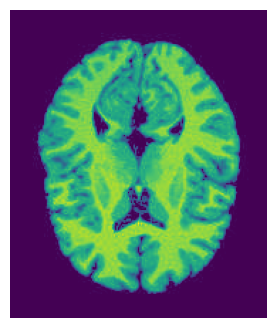

In [888]:
original = convert_to_2d_list(pixel_values_original, height, width)
plt.figure(figsize=(4, 4))  # Set the size of the figure
plt.axis('off')  # Turn off the axis
plt.imshow(original)

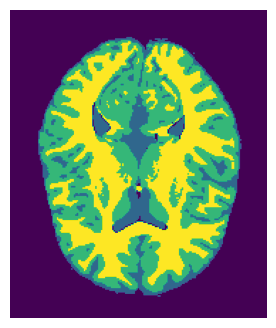

In [889]:
mask = convert_to_2d_list(pixel_values_mask, height, width)
plt.figure(figsize=(4, 4))  # Set the size of the figure
plt.axis('off')  # Turn off the axis
plt.imshow(mask)

In [890]:

X_test=[]
k=0
for i in range(width):
    for j in range(height):
        rows=[]
        rows.append(pixel_values_original[k])
        X_test.append(rows)
        k+=1
        
        
y_test=[]
k=0
for i in range(width):
    for j in range(height):
        y_test.append(pixel_values_mask[k])
        k+=1
scaler = StandardScaler() 
scaler.fit(X_test)
       
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled)
print(y_test)

[[-0.93833393]
 [-0.93833393]
 [-0.93833393]
 ...
 [-0.93833393]
 [-0.93833393]
 [-0.93833393]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [891]:
X_test=np.array(X_test_scaled)
y_test=np.array(y_test)

In [892]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on test data
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)



1228/1228 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Mean Absolute Error (MAE): 0.12483536889354757
Root Mean Squared Error (RMSE): 0.24940380214363617


c:\Users\Shruti Pathak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [893]:
from sklearn.metrics import accuracy_score

# Round the predictions to the nearest integer to get the predicted class
y_pred_class = np.round(y_pred).astype(int)

# Convert the ground truth labels to integer format if necessary
y_true_class = y_test.astype(int)

# Calculate accuracy score
accuracy = accuracy_score(y_true_class, y_pred_class)
print("Accuracy Score:", accuracy)



Accuracy Score: 0.9422308221096316


In [894]:
import os

# Define the directory path
directory = f'E:/Shruti/dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)



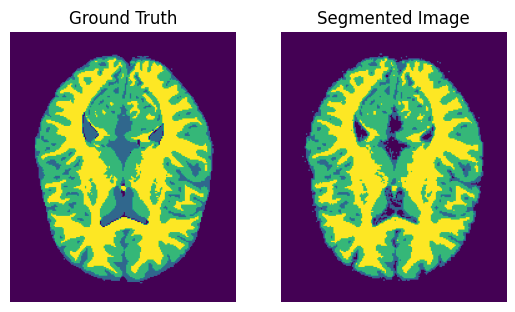

In [895]:
#print the ground truth and the segmented image

original = convert_to_2d_list(y_true_class, height, width)
predicted = convert_to_2d_list(y_pred_class, height, width)

# Plotting original and predicted images
plt.subplot(1, 2, 1)  
plt.imshow(original)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 2, 2)  
plt.imshow(predicted)
plt.title('Segmented Image')
plt.axis('off')

# Save the plot
plt.savefig(os.path.join(directory, 'original_vs_predicted.png'))

# Display the plot
plt.show()

In [896]:
ori_csf=[]
pred_csf=[]

for i in y_true_class:
    if(i==1):
        ori_csf.append(255)
    else:
        ori_csf.append(0)

for i in y_pred_class:
    if(i==1):
        pred_csf.append(255)
    else:
        pred_csf.append(0)

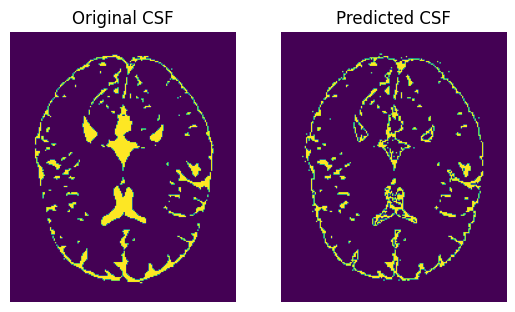

In [897]:
original_csf = convert_to_2d_list(ori_csf, height, width)
predicted_csf = convert_to_2d_list(pred_csf, height, width)

# Plotting original image
plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, and this being the first subplot
plt.imshow(original_csf)
plt.title('Original CSF')
plt.axis('off')

# Plotting predicted image
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, and this being the second subplot
plt.imshow(predicted_csf)
plt.title('Predicted CSF')
plt.axis('off')

# Save the plot
plt.savefig(os.path.join(directory, 'original_csf_vs_predicted_csf.png'))

# Display the plot
plt.show()

In [898]:
ori_gm=[]
pred_gm=[]

for i in y_true_class:
    if(i==2):
        ori_gm.append(255)
    else:
        ori_gm.append(0)

for i in y_pred_class:
    if(i==2):
        pred_gm.append(255)
    else:
        pred_gm.append(0)

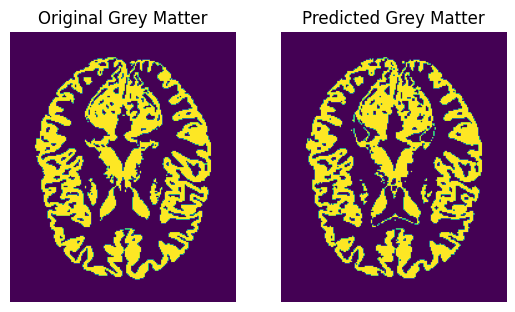

In [899]:
original_gm = convert_to_2d_list(ori_gm, height, width)
predicted_gm = convert_to_2d_list(pred_gm, height, width)

# Plotting original image
plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, and this being the first subplot
plt.imshow(original_gm)
plt.title('Original Grey Matter')
plt.axis('off')

# Plotting predicted image
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, and this being the second subplot
plt.imshow(predicted_gm)
plt.title('Predicted Grey Matter')
plt.axis('off')
# Save the plot
plt.savefig(os.path.join(directory, 'original_gm_vs_predicted_gm.png'))

# Display the plot
plt.show()


In [900]:
ori_wm=[]
pred_wm=[]

for i in y_true_class:
    if(i==3):
        ori_wm.append(255)
    else:
        ori_wm.append(0)

for i in y_pred_class:
    if(i==3):
        pred_wm.append(255)
    else:
        pred_wm.append(0)

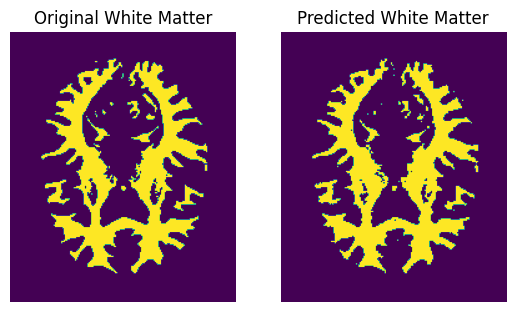

In [901]:
original_wm = convert_to_2d_list(ori_wm, height, width)
predicted_wm = convert_to_2d_list(pred_wm, height, width)

# Plotting original image
plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, and this being the first subplot
plt.imshow(original_wm)
plt.title('Original White Matter')
plt.axis('off')

# Plotting predicted image
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, and this being the second subplot
plt.imshow(predicted_wm)
plt.title('Predicted White Matter')
plt.axis('off')
# Save the plot
plt.savefig(os.path.join(directory, 'original_wm_vs_predicted_wm.png'))

# Display the plot
plt.show()